In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

In [2]:
df=pd.read_csv("/content/drive/MyDrive/Post_DC/df.csv")
df.drop(columns=['Unnamed: 0'],inplace=True, axis=1)
df['coin']=df['coin'].str[:-4]
print(df.shape)
df.head()

(182855, 30)


,Date,Open,High,Low,Close,Adj Close,Volume,coin,Market_Cap,Pct_Change,...,Open_1m_std,Open_3m_std,Open_6m_std,Open_12m_std,Open_24m_std,Open_1m_volatility,Open_3m_volatility,Open_6m_volatility,Open_12m_volatility,Open_24m_volatility
0,2019-01-01,0.002876,0.002930,0.002784,0.002913,0.002913,331289.0,AAC,965.044878,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-02,0.002928,0.002953,0.002757,0.002872,0.002872,305086.0,AAC,876.206987,-1.407486,...,0.000037,0.000037,0.000037,0.000037,0.000037,NaN,NaN,NaN,NaN,NaN
2,2019-01-03,0.002869,0.003170,0.002736,0.002900,0.002900,317624.0,AAC,921.109588,0.974930,...,0.000032,0.000032,0.000032,0.000032,0.000032,0.027033,0.027033,0.027033,0.027033,0.027033
3,2019-01-04,0.002898,0.002986,0.002797,0.002901,0.002901,435891.0,AAC,1264.519778,0.034483,...,0.000027,0.000027,0.000027,0.000027,0.000027,0.020169,0.020169,0.020169,0.020169,0.020169
4,2019-01-05,0.002898,0.003046,0.002845,0.002907,0.002907,518812.0,AAC,1508.186493,0.206827,...,0.000023,0.000023,0.000023,0.000023,0.000023,0.016522,0.016522,0.016522,0.016522,0.016522


In [3]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'coin',
       'Market_Cap', 'Pct_Change', 'Month_Year', 'PD', 'isPenny', 'drawdown',
       'drawdown_percentage', 'Open_1m_avg', 'Open_3m_avg', 'Open_6m_avg',
       'Open_12m_avg', 'Open_24m_avg', 'Open_1m_std', 'Open_3m_std',
       'Open_6m_std', 'Open_12m_std', 'Open_24m_std', 'Open_1m_volatility',
       'Open_3m_volatility', 'Open_6m_volatility', 'Open_12m_volatility',
       'Open_24m_volatility'],
      dtype='object')

In [4]:
df1 = df[[ 'Open_1m_avg','drawdown', 'PD']]

inliers = df1[df1['PD'] == 0].sample(n=5000, random_state=1).reset_index(drop=True)
outliers = df1[df1['PD'] == 1]

inliers = inliers.drop(columns=['PD'])
outliers = outliers.drop(columns=['PD'])

inliers_log_transformed = np.log(inliers + 1)
outliers_log_transformed = np.log(outliers + 1)

scaler = MinMaxScaler()
inliers_scaled = scaler.fit_transform(inliers_log_transformed)
outliers_scaled = scaler.transform(outliers_log_transformed)

In [5]:
ocsvm = OneClassSVM(kernel='poly', gamma='auto', nu=0.1)
ocsvm.fit(inliers_scaled)

inliers_pred = ocsvm.predict(inliers_scaled)
outliers_pred = ocsvm.predict(outliers_scaled)

inliers_pred = np.where(inliers_pred == 1, 1, 0)
outliers_pred = np.where(outliers_pred == 1, 1, 0)

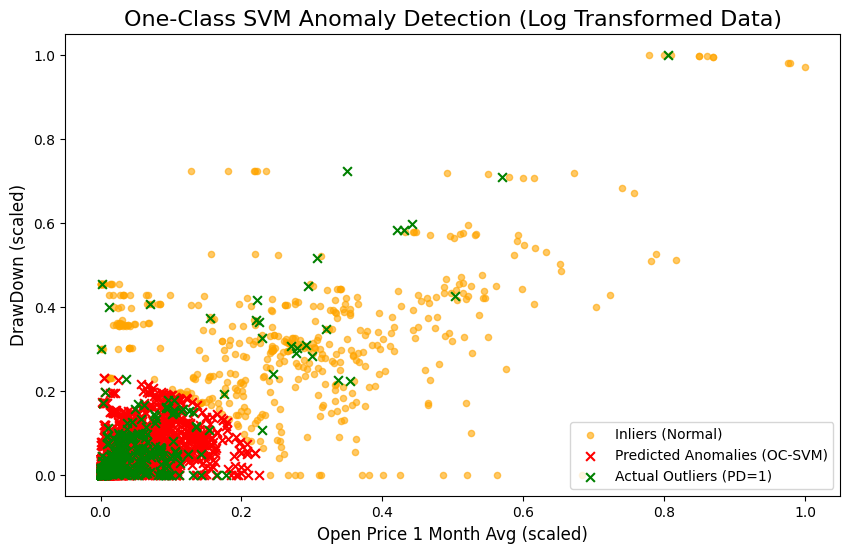

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(inliers_scaled[inliers_pred == 1, 0], inliers_scaled[inliers_pred == 1, 1], color='Orange', s=20, label='Inliers (Normal)', alpha=0.6)

ax.scatter(inliers_scaled[inliers_pred == 0, 0], inliers_scaled[inliers_pred == 0, 1], color='red', s=40, label='Predicted Anomalies (OC-SVM)', marker='x')

ax.scatter(outliers_scaled[:, 0], outliers_scaled[:, 1], color='green', s=40, label='Actual Outliers (PD=1)', marker='x')

ax.set_title('One-Class SVM Anomaly Detection (Log Transformed Data)', fontsize=16)
ax.set_xlabel('Open Price 1 Month Avg (scaled)', fontsize=12)
ax.set_ylabel('DrawDown (scaled)', fontsize=12)
ax.legend(loc='lower right')
plt.show()